# Дипломная работа

# по курсу

# Feature engineering

Поздравляю вас, теперь вы вооружены знаниями по предобработке данных, и пора применить их на интересном кейсе.

Представлены данные такси, по которым мы должны предсказать возьмёт ли таксист заказ или нет(driver_response).

Принципы вы знаете, чек-лист аналогичен лабораторной работе.

Чек-лист:
1. Загрузите датасет taxi.csv.
2. Посмотрите на данные. Отобразите общую информацию по признакам (вспомните о describe и info). Напишите в markdown свои наблюдения.
3. Выявите пропуски, а также возможные причины их возникновения. Решите, что следует сделать с ними. Напишите в markdown свои наблюдения.
4. Оцените зависимости переменных между собой. Используйте корреляции. Будет хорошо, если воспользуетесь profile_report. Напишите в markdown свои наблюдения.
5. Определите стратегию преобразования категориальных признаков (т.е. как их сделать адекватными для моделей).
6. Найдите признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалите лишние, при необходимости.
7. Разделите выборку на обучаемую и тестовую.
8. Обучите модель. Напишите в markdown свои наблюдения по полученным результатам. Хорошие результаты дают классификаторы RandomForest и XGBoost

In [3]:
%matplotlib inline

import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [4]:
df = pd.read_csv('taxi.csv')

df.head(10)

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0   1105373            5        20       6080    174182        55.818842   
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
3    889660            2         6       6080    163522        55.745922   
4   1120055            4        16       6080    506710        55.803578   
5   1058203            6        15       6080    360328        55.818963   
6    103326            2        11       6080    615584        55.753508   
7    128861            5        20       6080    254374        55.839318   
8    493006            5        20       6080    753429        55.818748   
9    953983            6         7       6080    533820        55.839155   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
0         37.334562              55.814567               37.355010   
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
3         37.421748              55.743469               37.431130   
4         37.521602              55.812559               37.527407   
5         37.361033              55.814827               37.354074   
6         37.663742              55.757251               37.659064   
7         37.248862              55.839134               37.304101   
8         37.338240              55.835764               37.294710   
9         37.251947              55.833198               37.312197   

   distance_km  duration_min offer_class_group ride_type_desc  driver_response  
0       -1.000        -1.000           Economy        private                0  
1       18.802        25.217          Standard        private                1  
2        6.747         9.800           Economy        private                0  
3       -1.000        -1.000           Economy        private                1  
4       12.383        19.250           Economy        private                1  
5        6.747         9.800           Economy        private                0  
6       -1.000        -1.000          Standard       business                1  
7        1.517         3.933           Economy        private                0  
8        6.222        15.433           Economy        private                0  
9       10.410        23.083           Economy        private                0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


### Описание датасета

- 'offer_gk' - уникальный ID сделки,
- 'weekday_key' - номер дня недели (Воскресенье - 0, Понедельник - 1, и т.д.),
- 'hour_key' - час (от 0 до 23),
- 'driver_gk' - уникальный ID водителя,
- 'order_gk' - уникальный ID заявки,
- 'driver_latitude' - координаты водителя (широта),
- 'driver_longitude' - координаты водителя (долгота),
- 'origin_order_latitude' - координаты пассажира (широта),
- 'origin_order_longitude' - координаты пассажира (долгота),
- 'distance_km' - расчётная дистанция поездки (значение -1 значит, что точка назначения не задана),
- 'duration_min' - расчётное время поездки (значение -1 значит, что точка назначения не задана),
- 'offer_class_group' - класс заказа,
- 'ride_type_desc' - тип заказа,
- 'driver_response' - решение водителя,

## Анализ нашего датасета.

#### offer_gk
Данный столбец указывает уникальный ID сделки, который мы можем удалить, поскольку это никак не повлияет на нашу модель.

#### weekday_key
Данный столбец указывает является важным. Он нам указывает дни (рабочие смены водителей).

#### hour_key
Данный столбец скорее всего указывает время заказа такси.

#### driver_gk
ID водителя - данный столбец необходим.

#### order_gk
ID заявки - данный столбец тоже необходим. По этому столбцу можно выяснить какая заявка была принята тем или иным водителем.

#### driver_latitude
Данный столбец дает нам координаты по широте для водителя

#### driver_longitude
Данный столбец дает нам координаты по долготе для водителя

driver_latitude и driver_longitude образуют координаты водителя.

#### origin_order_latitude
Столбец заказа такси со значением широты

#### origin_order_longitude
Столбец заказа такси со значением долготы

origin_order_latitude и origin_order_longitude образуют координаты пассажира

#### distance_km
Дистанция в километрах пройденного пути от точки где пассажир совершил посадку, и где пассажир вышел.

#### duration_min	
Продолжительность поездки в минутах пройденного пути от точки где пассажир совершил посадку, и где пассажир вышел.

#### offer_class_group
Класс заказа, который может влиять на то, возьмет ли пассажир тот или иной класс в зависимости от срочности поездки, цены и прочих факторов. Например пассажир куда-нибудь торопится и рядом оказался не эконом класс, а стандарт.

#### ride_type_desc
Тип заказа, частная или деловая поездка. Скорее всего это означает оплата заказа физическим или юридическим лицом, как вариант.

#### driver_response
Решение водителя, взял  заказ или нет.


## Удалим ненужные колонки и проверим разные выбросы.

In [6]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

weekday_key       hour_key  driver_latitude  driver_longitude  \
count  100000.000000  100000.000000    100000.000000     100000.000000   
mean        3.159860      13.827790        55.700824         37.492292   
std         2.054222       7.306496         2.135903          1.454640   
min         0.000000       0.000000        -1.000000         -1.000000   
25%         1.000000       8.000000        55.708651         37.413497   
50%         3.000000      16.000000        55.772904         37.533664   
75%         5.000000      20.000000        55.960667         37.624113   
max         6.000000      23.000000        56.174097         38.280547   

       origin_order_latitude  origin_order_longitude    distance_km  \
count          100000.000000           100000.000000  100000.000000   
mean               55.772440               37.541637      18.393518   
std                 0.665985                0.467758      41.129296   
min                -1.000000               -1.000000      -1.000000   
25%                55.708032               37.407117      -1.000000   
50%                55.772561               37.532537      10.411500   
75%                55.962000               37.624358      30.665250   
max                56.311121               38.243608    5234.283000   

        duration_min  driver_response  
count  100000.000000    100000.000000  
mean       23.134841         0.492480  
std        33.890105         0.499946  
min        -1.000000         0.000000  
25%        -1.000000         0.000000  
50%        19.700000         0.000000  
75%        37.867000         1.000000  
max      3958.283000         1.000000

В приведенной таблице видно отсутствие данных в следующих столбцах:
- 'driver_latitude',
- 'driver_longitude',
- 'origin_order_latitude',
- 'origin_order_longitude',
- 'distance_km',
- 'duration_min',

Так же есть непонятные данные в следующих столбцах:
- 'distance_km',
- 'duration_min',

In [7]:
df[df['driver_latitude'] == -1].shape, df[df['driver_longitude'] == -1].shape


((140, 14), (140, 14))

In [8]:
df[df['driver_latitude'] == 0].shape, df[df['driver_longitude'] == 0].shape

((1, 14), (1, 14))

In [9]:
driver_lat_indexes = df[df['driver_latitude'] == -1].index
driver_lon_indexes = df[df['driver_longitude'] == -1].index

False in (driver_lat_indexes == driver_lon_indexes)

False

In [10]:
driver_zero_lat_indexes = df[df['driver_latitude'] == 0].index
driver_zero_lon_indexes = df[df['driver_longitude'] == 0].index

False in (driver_lat_indexes == driver_lon_indexes)

False

In [11]:
df[df['origin_order_latitude'] == -1].shape, df[df['origin_order_longitude'] == -1].shape

((13, 14), (13, 14))

In [12]:
origin_lat_indexes = df[df['origin_order_latitude'] == -1].index
origin_lon_indexes = df[df['origin_order_longitude'] == -1].index

False in (origin_lat_indexes == origin_lon_indexes)

False

Удалим пару записей 

In [13]:
df.drop([*driver_lat_indexes, *origin_lat_indexes, *driver_zero_lat_indexes], inplace=True)

In [14]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

weekday_key      hour_key  driver_latitude  driver_longitude  \
count  99846.000000  99846.000000     99846.000000      99846.000000   
mean       3.160087     13.826633        55.780883         37.546631   
std        2.054477      7.308449         0.153851          0.157053   
min        0.000000      0.000000        55.327636         36.984771   
25%        1.000000      8.000000        55.709285         37.413497   
50%        3.000000     16.000000        55.773085         37.533874   
75%        5.000000     20.000000        55.960697         37.624235   
max        6.000000     23.000000        56.174097         38.280547   

       origin_order_latitude  origin_order_longitude   distance_km  \
count           99846.000000            99846.000000  99846.000000   
mean               55.780195               37.546311     18.411756   
std                 0.156106                0.159887     41.150869   
min                55.327917               36.994072     -1.000000   
25%                55.708502               37.407117     -1.000000   
50%                55.772734               37.532189     10.441500   
75%                55.962035               37.624145     30.694750   
max                56.172361               38.243608   5234.283000   

       duration_min  driver_response  
count  99846.000000     99846.000000  
mean      23.159030         0.491757  
std       33.901266         0.499935  
min       -1.000000         0.000000  
25%       -1.000000         0.000000  
50%       19.750000         0.000000  
75%       37.883000         1.000000  
max     3958.283000         1.000000

Теперь в датасете признаки координатов и водителя, и пассажира не содержат выбросов.

Теперь посмотрим, сколько отсутствующих значений в признаках 'distance_km' и 'duration_min'

In [15]:
df[df['distance_km'] == -1].shape, df[df['duration_min'] == -1].shape

((26083, 14), (26083, 14))

In [16]:
False in (df[df['distance_km'] == -1].index == df[df['duration_min'] == -1].index)

False

Проверим, есть ли нулевые значения в этих признаках

In [17]:
df[df['distance_km'] == 0].shape, df[df['duration_min'] == 0].shape

((152, 14), (152, 14))

In [18]:
distance_km_zero_indexes = df[df['distance_km'] == 0].index
duration_min_zero_indexes = df[df['duration_min'] == 0].index

False in (distance_km_zero_indexes == duration_min_zero_indexes)

False

Удалим нулевые значения.

In [19]:
df.drop([*distance_km_zero_indexes], inplace=True)

In [20]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

weekday_key      hour_key  driver_latitude  driver_longitude  \
count  99694.000000  99694.000000     99694.000000      99694.000000   
mean       3.160200     13.829057        55.780892         37.546583   
std        2.054376      7.307393         0.153854          0.157035   
min        0.000000      0.000000        55.327636         36.984771   
25%        1.000000      8.000000        55.709286         37.413497   
50%        3.000000     16.000000        55.773095         37.533859   
75%        5.000000     20.000000        55.960702         37.624205   
max        6.000000     23.000000        56.174097         38.280547   

       origin_order_latitude  origin_order_longitude   distance_km  \
count           99694.000000            99694.000000  99694.000000   
mean               55.780203               37.546266     18.439828   
std                 0.156108                0.159867     41.175943   
min                55.327917               36.994072     -1.000000   
25%                55.708502               37.407117     -1.000000   
50%                55.772737               37.532150     10.473500   
75%                55.962035               37.624094     30.733500   
max                56.172361               38.243608   5234.283000   

       duration_min  driver_response  
count  99694.000000     99694.000000  
mean      23.194340         0.491765  
std       33.915028         0.499935  
min       -1.000000         0.000000  
25%       -1.000000         0.000000  
50%       19.791500         0.000000  
75%       37.917000         1.000000  
max     3958.283000         1.000000

В нашем датасете есть какие-то странные и длительные поездки. Мы можем их удалить, поскольку это может навредить нашей модели.
Оставим поездки до 300км, к примеру. И будем обучать нашу модель на корректном (немного урезанном) датасете.

In [21]:
df.drop(df[df['distance_km'] > 300].index, inplace=True)

In [22]:
df.drop(['offer_gk', 'driver_gk', 'order_gk'], axis=1).describe()

weekday_key      hour_key  driver_latitude  driver_longitude  \
count  99633.000000  99633.000000     99633.000000      99633.000000   
mean       3.159887     13.828290        55.780962         37.546525   
std        2.054454      7.307831         0.153821          0.156996   
min        0.000000      0.000000        55.327636         36.984771   
25%        1.000000      8.000000        55.709304         37.413497   
50%        3.000000     16.000000        55.773159         37.533821   
75%        5.000000     20.000000        55.960729         37.624138   
max        6.000000     23.000000        56.174097         38.280547   

       origin_order_latitude  origin_order_longitude   distance_km  \
count           99633.000000            99633.000000  99633.000000   
mean               55.780274               37.546206     17.829222   
std                 0.156073                0.159825     20.404032   
min                55.327917               36.994072     -1.000000   
25%                55.708573               37.407117     -1.000000   
50%                55.772774               37.532104     10.463000   
75%                55.962046               37.623950     30.682000   
max                56.172361               38.243608    254.061000   

       duration_min  driver_response  
count  99633.000000     99633.000000  
mean      22.738488         0.491644  
std       20.833462         0.499933  
min       -1.000000         0.000000  
25%       -1.000000         0.000000  
50%       19.767000         0.000000  
75%       37.883000         1.000000  
max      221.917000         1.000000

### Поиск призанков для дальнейшей их генерация в новые признаки.

Выполним поиск категориальных признаков на примере колонки offer_class_group и ride_type_desc

In [23]:
df['offer_class_group'].unique()

array(['Economy', 'Standard', 'XL', 'Kids', 'Delivery', 'Test', 'Premium',
       'VIP', 'VIP+'], dtype=object)

In [24]:
df['ride_type_desc'].unique()

array(['private', 'business', 'affiliate', 'SMB'], dtype=object)

In [25]:
df.reset_index(drop=True).shape

(99633, 14)

In [26]:
df = df[df['offer_class_group'] != 'Test']

df.reset_index(drop=True).shape

(99625, 14)

Зададим вспомогательную функцию.

In [28]:
def calc_vector_len(row):
    """
    Фнукция принимает ряд из датасета и считает рассточние между позицией водителя
    и позицией клиента в момент заказа такси.
    """
    return np.linalg.norm([
        row['driver_latitude'] - row['origin_order_latitude'],
        row['driver_longitude'] - row['origin_order_longitude'],
    ])

In [29]:
df['driver_origin_distance'] = df.apply(calc_vector_len, axis=1)

In [30]:
df.head()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0   1105373            5        20       6080    174182        55.818842   
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
3    889660            2         6       6080    163522        55.745922   
4   1120055            4        16       6080    506710        55.803578   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
0         37.334562              55.814567               37.355010   
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
3         37.421748              55.743469               37.431130   
4         37.521602              55.812559               37.527407   

   distance_km  duration_min offer_class_group ride_type_desc  \
0       -1.000        -1.000           Economy        private   
1       18.802        25.217          Standard        private   
2        6.747         9.800           Economy        private   
3       -1.000        -1.000           Economy        private   
4       12.383        19.250           Economy        private   

   driver_response  driver_origin_distance  
0                0                0.020890  
1                1                0.050597  
2                0                0.006442  
3                1                0.009697  
4                1                0.010694

Так же, в изначальный датасет я добавлю категориальные признаки при помощи OneHotEncoding подхода

In [31]:
df = pd.get_dummies(df)

df.columns

Index(['offer_gk', 'weekday_key', 'hour_key', 'driver_gk', 'order_gk',
       'driver_latitude', 'driver_longitude', 'origin_order_latitude',
       'origin_order_longitude', 'distance_km', 'duration_min',
       'driver_response', 'driver_origin_distance',
       'offer_class_group_Delivery', 'offer_class_group_Economy',
       'offer_class_group_Kids', 'offer_class_group_Premium',
       'offer_class_group_Standard', 'offer_class_group_VIP',
       'offer_class_group_VIP+', 'offer_class_group_XL', 'ride_type_desc_SMB',
       'ride_type_desc_affiliate', 'ride_type_desc_business',
       'ride_type_desc_private'],
      dtype='object')

Сейчас я хочу сразу же совладать с нашими многочисленными признаками и сгруппирую их названия по категориям

In [32]:
col_names = {
    'ids': ['offer_gk', 'driver_gk', 'order_gk'],
    
    'time_keys': ['weekday_key', 'hour_key'],
    
    'coords': ['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'],
    
    'dest': ['distance_km', 'duration_min'],
    
    'time_rank': ['time_rank'],
    
    'offer_class_rank': ['offer_class_group_rank'],
    
    'ride_type_rank': ['ride_type_desc_rank'],
    
    'weekday_key_rank': ['weekday_key_rank'],
    
    'hour_key_rank': ['hour_key_rank'],
    
    'driver_origin_distance': ['driver_origin_distance'],
    
    'offer_class_features': [
        'offer_class_group_Delivery',
        'offer_class_group_Economy',
        'offer_class_group_Kids',
        'offer_class_group_Premium',
        'offer_class_group_Standard',
        'offer_class_group_VIP',
        'offer_class_group_VIP+',
        'offer_class_group_XL'
    ],
    
    'ride_type_features': [
        'ride_type_desc_SMB',
        'ride_type_desc_affiliate',
        'ride_type_desc_business',
        'ride_type_desc_private',
    ],    
    
    'target_value': ['driver_response'],
}

In [33]:
df_with_dest = df[df[col_names['dest'][0]] != -1]
df_without_dest = df[df[col_names['dest'][0]] == -1].drop([*col_names['dest']], axis=1)

In [34]:
df_with_dest.shape, df_without_dest.shape

((73550, 25), (26075, 23))

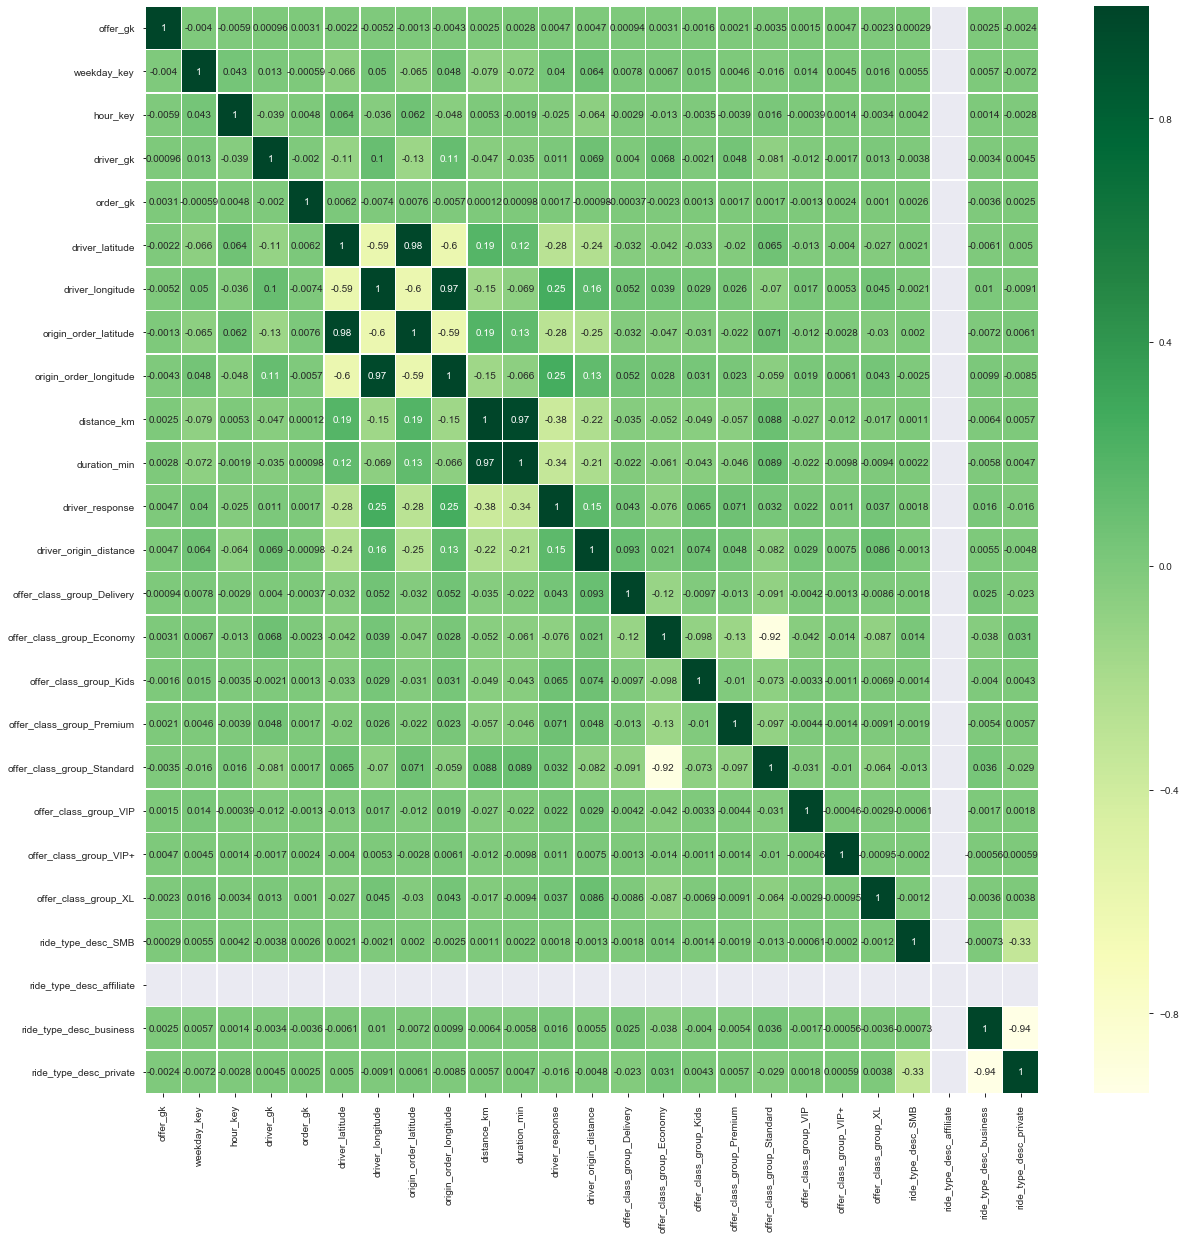

In [35]:
plt.figure(figsize=(20, 20))

sns.heatmap(df_with_dest.corr(method='spearman'), annot=True, linewidths=0.5, cmap='YlGn')
plt.show()

есть пропуски по данным offer_class_group_Test

In [36]:
df_with_dest.profile_report(style={ 'full_width': True })

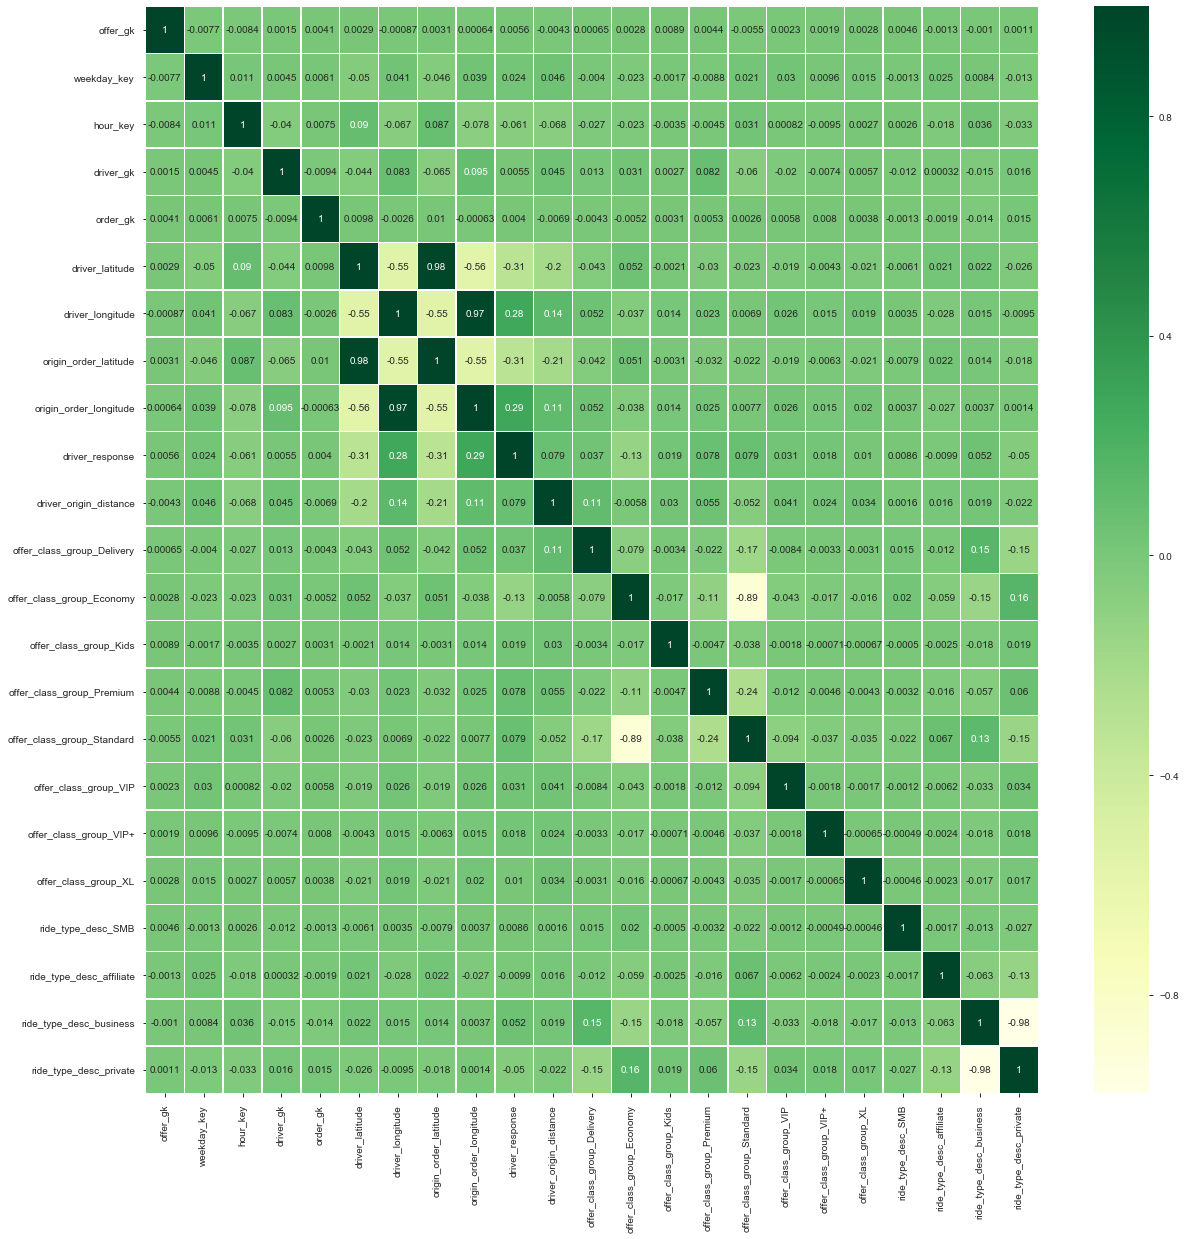

In [38]:
plt.figure(figsize=(20, 20))

sns.heatmap(df_without_dest.corr(method='spearman'), annot=True, linewidths=0.5, cmap='YlGn')
plt.show()

In [37]:
df_without_dest.profile_report(style={ 'full_width': True })

Здесь видно, что высокую корреляцию между собой имеют следующие признаки:

- время и дистанция поездки;

- широта из координат водителя и клиента;

- долгота из координат водителя и клиента;

- ранг поездки и бизнес тип поездки;

- час и временной ранг;

Это говорит нам о том, что с использование именно этих признаков сможет сильно повлиять на мою модель

### Модели с известной точкой назначения

In [109]:
rfc = RandomForestClassifier(n_estimators=200)

### Сейчас я оставлю меньше категориальных признаков, разделю на две модели:

In [120]:
X_data = df_with_dest[[
    *col_names['driver_origin_distance'],
    *col_names['offer_class_features'],
    *col_names['ride_type_features'],
    *col_names['time_keys'],
    *col_names['coords'],
    *col_names['dest'],
]]

Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

0.7365605901093558

Проверим, что получится, если оставить только остальные признаки, убрав фичи

In [119]:
X_data = df_with_dest[[
    *col_names['time_keys'],
    *col_names['coords'],
    *col_names['dest'],
]]

Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

0.723834179964187

In [145]:
X_data = df_with_dest[[
    *col_names['coords'],
    *col_names['dest'],
]]

Y_data = df_with_dest[[*col_names['target_value']]]

cross_val_score(rfc, X_data, Y_data, cv=5).mean()

0.7082869034744014

### Итого: максимальный результат ~74% точности.